# Tarea 2

Importamos las librerias necesarias

In [1]:
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import numpy as np

Lectura del archivo FITS

In [2]:
#esta es una forma "automatizada" de obtener la velocidad(v) longitud(l) y latitud(b)
#esta funcion les entrega un arreglo con los valores reales del eje correspondiente
#1 es velocidad, 2 es longitud galactica, 3 es latitud galactica
def values(h,j):
    N=h['NAXIS'+str(j)];
    val=np.zeros(N);
    for i in range(0,N):
        val[i] = (i+1-float(h['CRPIX'+str(j)]))*float(h['CDELT'+str(j)]) + float(h['CRVAL'+str(j)]);
    return val;

cubo    = fits.open("cubo_de_datos.fits") #abrir objeto cubo de datos
data    = cubo[0].data #extraer matriz de datos
header  = cubo[0].header #extraer el header del archivo fits


#Estos seran los tres arreglos con los valores reales de los tres ejes del cubo
velocidad = values(header,1)
longitud  = values(header,2)
latitud = values(header,3)

## Curva de rotacion

R0=8.5 kpc es la distancia radial del Sol al centro de la galaxia, l la longitud y ω(R) es la velocidad angular con respecto al centro de la galaxia V(R_0) es la velocidad del sol respecto al centro galáctico, el valor de esta constante, corresponde a 220[km/s]. La curva de rotacion se calcula con la siguiente expresion:

\begin{align}
V (R=R_0 sin(l)) =  \omega (R=R_0 sin(l)) \cdot R_0 · |sin(l)| 
\end{align}

In [3]:
# Se crea una funcion que para un indice de longitud(l) fija, se recorre latitud(b) y se calcula el rms de las
# velocidades
# Esta misma funcion recorre el cubo de las velocidades asociadas a l y b, hasta que se llega a una
# velocidad que es 5 veces mayor que el rms, esta ultima se guarda un arreglo

def fmin(l, vs):
    #recorre latitud
    for q in range(33):
        T1=data[q][l][:]
        rms=np.sqrt(np.mean(T1**2))   #calcula rms
        #recorre velocidad
        for w in range(306):
            if data[q][l][w]>=5*rms:  #buscamos que no sea ruido
                vs[q]=velocidad[w]    #guardamos la primera v donde T mayor a 5rms
                break

vmin=np.zeros(385)
bvmin=np.zeros(385)
R=np.zeros(385)
R0=8.5 #kPc
vsol=220 #km/s

#maximorum
# Se recorren las longitudes y se busca la velocidad más negativa (mayor en modulo), se guarda esta
# y su latitud asociada
# Se obtiene un arreglo de R con la ecuacion R =| R0 · cos(l π/180 ) |

for i in range(385):
    vs=np.zeros(33)
    fmin(i, vs)
    v1=vs[0]
    b1=latitud[0]
    for j in range(32):
        if vs[j+1]<v1:
            v1=vs[j+1]
            b1=latitud[j+1]
    vmin[i]=v1
    bvmin[i]=b1
    R[i]=np.abs(R0*np.sin(longitud[i]*np.pi/180.)) #R0*sin(l)

    
# Se obtiene la Vtan con Vtan = −Vmin − Vsol · sin(lπ/180 ), donde Vmin es la velocidad mayor en
# modulo para l, y Vsol es la velocidad de rotacion del sol.

#velocidad de rotacion
vR = np.zeros(385)
wR=np.zeros(385)

for i in range(385):
    vR[i]= abs(vmin[i])+ vsol*abs(np.sin(longitud[i]*np.pi/180.))
    
# velocidad angular
wR = vR/R

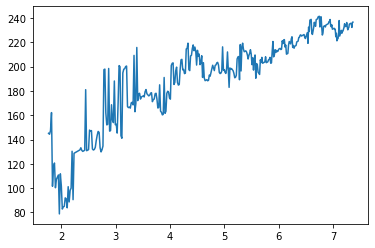

In [4]:
# Grafico vR vs R
plt.plot(R, vR)
plt.show()

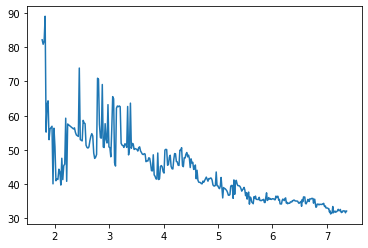

In [5]:
# Grafico v angular vs R
plt.plot(R, wR)
plt.show()

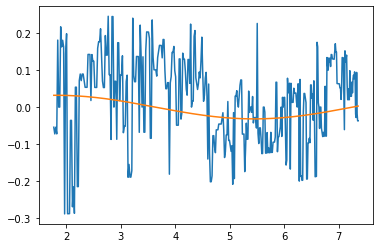

In [6]:
Z = bvmin*(np.pi/180)*R0*np.cos(longitud*np.pi/180)


def seno(R, f, A):
    return A*np.sin(R*f)  

fitZ, covZ= curve_fit(seno, R, Z)


plt.plot(R, Z)
plt.plot(R, seno(R, fitZ[0], fitZ[1]))
plt.show()

## Modelos de distribución de masa para la curva de rotación


En la siguientes celdas veremos como ajustar un modelo de masa a la curva de rotación de la galaxia. Si asumimos que la galaxia tiene un perfil de masa M(r), entonces su velocidad será:

\begin{align}
v(r) =   \frac{GM(r)}{R}
\end{align}


Veremos el caso de una masa puntual $M_{0}$, para este caso tendremos que la velocidad puede expresarse en funcion del radio como:

\begin{align}
v(r) =   \frac{GM_{0}}{R}
\end{align}

Ajustaremos este modelo de distribucion de masa ocupando curve_fit de scipy

In [24]:
#definimos la constante G en unidades adecuadas
G=4.302e-6 # Units: kpc x M_sun^(-1) x (km/s)^2 

# funciones de velocidad para diferentes distribuciones de masa:

def masa(R,M0):
    M=M0
    v=np.sqrt(G*M/R)
    return v

def esfera_uniforme(R, rho):
    M = (4/3) * np.pi * (R**3) * rho
    v = np.sqrt(G*M/R)
    return v

def esfera_masa(R, M0, rho):
    M = (4/3) * np.pi * (R**3) * rho + M0
    v = np.sqrt(G*M/R)
    return v

def disco_uniforme(R, s):
    M = np.pi * (R**2) * s
    v = np.sqrt(G*M/R)
    return v

def disco_masa(R, M0, s):
    M = np.pi * (R**2) * s + M0
    v = np.sqrt(G*M/R)
    return v

Se realizan los ajustes correspondientes:

In [45]:
masa_p     , covmasa_p      = curve_fit(masa           ,R, vR)
esfera_uni , covesfera_uni  = curve_fit(esfera_uniforme,R, vR)
esfera_mas , covesfera_mas  = curve_fit(esfera_masa    ,R, vR)
disco_uni  , covdisco_uni   = curve_fit(disco_uniforme ,R, vR)
disco_mas  , covdisco_mas   = curve_fit(disco_masa     ,R, vR)

Graficos

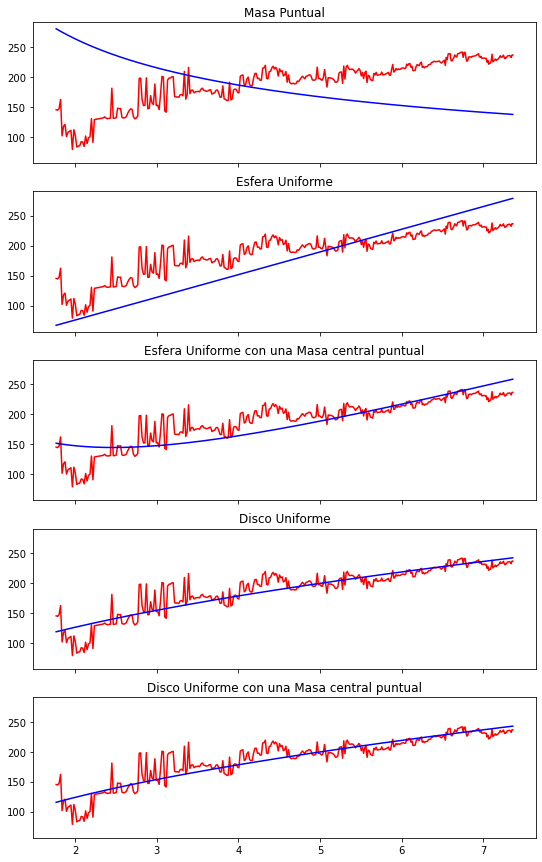

In [46]:
#Graficamos el ajuste
fig, axs = plt.subplots(5, 1, sharey=True, sharex=True, figsize=(9,15))

axs[0].plot(R, vR, 'r',label='Datos')
axs[0].plot(R, masa(R, masa_p[0]), 'b',label='Masa Puntual')
axs[0].set_title('Masa Puntual')

axs[1].plot(R, vR, 'r',label='Datos')
axs[1].plot(R, esfera_uniforme(R, esfera_uni[0]), 'b',label='Esfera Uniforme')
axs[1].set_title('Esfera Uniforme')

axs[2].plot(R, vR, 'r',label='datos')
axs[2].plot(R, esfera_masa(R, esfera_mas[0], esfera_mas[1]), 'b',label='Esfera + Masa Puntual')
axs[2].set_title('Esfera Uniforme con una Masa central puntual')

axs[3].plot(R, vR, 'r',label='datos')
axs[3].plot(R, disco_uniforme(R, disco_uni[0]), 'b',label='Disco Uniforme')
axs[3].set_title('Disco Uniforme')

axs[4].plot(R, vR, 'r',label='datos')
axs[4].plot(R, disco_masa(R, disco_mas[0], disco_mas[1]), 'b',label='Disco + Masa')
axs[4].set_title('Disco Uniforme con una Masa central puntual')
plt.show()

El disco uniforme y el disco con masa puntual son los que mas se acercan a la curva de rotacion, para obtener una respuesta definitiva comparemos el error cuadrático medio entre estos dos modelos

In [47]:

def vel(R, M):
    return np.sqrt(G*M/R)

def pointlike_mass_model(M0):
    """`M0` point mass in the center of the Galaxy."""
    return M0

def uniform_disk_mass_model(R, s):
    """`s` uniform superficial mass density."""
    return np.pi*R**2*s

def uniform_sphere_mass_model(R, rho):
    """`rho` uniform volumetric mass density."""
    return 4/3*np.pi*R**3*rho

def uniform_disk_and_pointlike_mass_model(R, s, M0):
    return uniform_disk_mass_model(R, s) + pointlike_mass_model(M0)

def uniform_sphere_and_pointlike_mass_model(R, rho, M0):
    return uniform_sphere_mass_model(R, rho) + pointlike_mass_model(M0)

popt_point, pcov_point = curve_fit(lambda R, M0: vel(R, pointlike_mass_model(M0)), R, vR)
perr_point = np.sqrt(np.diag(pcov_point))
popt_disk, pcov_disk = curve_fit(lambda R, s: vel(R, uniform_disk_mass_model(R, s)), R, vR)
perr_disk = np.sqrt(np.diag(pcov_disk))
popt_sphere, pcov_sphere = curve_fit(lambda R, rho: vel(R, uniform_sphere_mass_model(R, rho)), R, vR)
perr_sphere = np.sqrt(np.diag(pcov_sphere))
popt_disk_point, pcov_disk_point = curve_fit(lambda R, s, M0: vel(R, uniform_disk_and_pointlike_mass_model(R, s, M0)), R, vR)
perr_disk_point = np.sqrt(np.diag(pcov_disk_point))
popt_sphere_point, pcov_sphere_points = curve_fit(lambda R, rho, M0: vel(R, uniform_sphere_and_pointlike_mass_model(R, rho, M0)), R, vR)
perr_sphere_point = np.sqrt(np.diag(pcov_sphere_points))

In [48]:
popt_disk_point, disco_mas

(array([ 5.94137885e+08, -3.40278275e+08]),
 array([-3.40278275e+08,  5.94137885e+08]))

In [33]:
uni = disco_uniforme(R, disco_uni[0])
mas = disco_masa(R, disco_mas[0], disco_mas[1])

# calculo de la raiz del error cuadratico medio
error_uni = np.sqrt(sum((vR-uni)**2)/len(R))
error_masa = np.sqrt(sum((vR-mas)**2)/len(R))

In [34]:
print('uniforme:', error_uni)
print('masa:    ', error_masa)

uniforme: 14.783591622341362
masa:     14.783591622395504


In [35]:
print(disco_mas)

[3.68454490e-01 5.88778172e+08]


El error es menor en el modelo del disco de densidad uniforme con una masa puntual en su centro.